**Table of contents**<a id='toc0_'></a>    
- [Data Mining Lab 2 - Phase 2](#toc1_)    
  - [Before Starting](#toc1_1_)    
  - [Introduction](#toc1_2_)    
  - [**1. Data Preparation**](#toc1_3_)    
  - [**1.1 Load data**](#toc1_4_)    
    - [**1.2 Save data**](#toc1_4_1_)    
  - [**2. Large Language Models (LLMs)**](#toc1_5_)    
    - [Open-Source vs. Proprietary LLMs](#toc1_5_1_)    
    - [Why Use Code (API) for Data Mining?](#toc1_5_2_)    
    - [The Gemini API](#toc1_5_3_)    
    - [Interacting with the Gemini API](#toc1_5_4_)    
    - [**2.1 Text Prompting**](#toc1_5_5_)    
        - [**>>> Exercise 1 (Take home):**](#toc1_5_5_1_1_)    
    - [**2.2 Structured Output**](#toc1_5_6_)    
        - [**>>> Exercise 2 (Take home):**](#toc1_5_6_1_1_)    
    - [**2.3 Information Extraction and Grounding:**](#toc1_5_7_)    
      - [**`langextract`: A Library for Grounded Extraction**](#toc1_5_7_1_)    
        - [**2.3.1 Using PDF Documents:**](#toc1_5_7_1_1_)    
        - [**>>> Bonus Exercise 3 (Take home):**](#toc1_5_7_1_2_)    
    - [**2.4 Generating LLM Embeddings:**](#toc1_5_8_)    
        - [**>>> Exercise 4 (Take home):**](#toc1_5_8_1_1_)    
    - [**2.5 Retrieval-Augmented Generation (RAG)**](#toc1_5_9_)    
        - [**Actual answer in the URL:**](#toc1_5_9_1_1_)    
        - [**Content in the URL that might get into the generated answer because of similar semantic meaning:**](#toc1_5_9_1_2_)    
        - [**>>> Bonus Exercise 5 (Take home):**](#toc1_5_9_1_3_)    
    - [**2.6 Few-Shot Prompting Classification:**](#toc1_5_10_)    
        - [**>>> Exercise 6 (Take home):**](#toc1_5_10_1_1_)    
        - [**>>> Exercise 7 (Take home):**](#toc1_5_10_1_2_)    
    - [**2.7 Extra LLM Related Materials:**](#toc1_5_11_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Data Mining Lab 2 - Phase 2](#toc0_)
In this lab's phase 2 session we will focus on exploring some basic LLMs' applications with data.


## <a id='toc1_1_'></a>[Before Starting](#toc0_)

**Make sure you have installed all the required libraries and you have the environment ready to run this lab.**
    

---
## <a id='toc1_2_'></a>[Introduction](#toc0_)

**Dataset:** [SemEval 2017 Task](https://competitions.codalab.org/competitions/16380)

**Task:** Classify text data into 4 different emotions using word embeddings and other deep information retrieval approaches.

![pic0.png](./pics/pic0.png)

---
## <a id='toc1_3_'></a>[**1. Data Preparation**](#toc0_)

In [1]:
import pandas as pd
from IPython.display import display, Markdown
from dotenv import load_dotenv
import os
from google import genai
from google.genai import types
import pymupdf
from pydantic import BaseModel
import langextract as lx
import textwrap
import json
from google import genai
import pandas as pd
import time
from google.api_core import exceptions

---
## <a id='toc1_4_'></a>[**1.1 Load data**](#toc0_)

We start by loading the csv files into a single pandas dataframe for training and one for testing.

In [23]:
### training data
anger_train = pd.read_csv("data/semeval/train/anger-ratings-0to1.train.txt",
                         sep="\t", header=None,names=["id", "text", "emotion", "intensity"])
sadness_train = pd.read_csv("data/semeval/train/sadness-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_train = pd.read_csv("data/semeval/train/fear-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_train = pd.read_csv("data/semeval/train/joy-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

In [24]:
# combine 4 sub-dataset
train_df = pd.concat([anger_train, fear_train, joy_train, sadness_train], ignore_index=True)

In [25]:
### testing data
anger_test = pd.read_csv("data/semeval/dev/anger-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
sadness_test = pd.read_csv("data/semeval/dev/sadness-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_test = pd.read_csv("data/semeval/dev/fear-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_test = pd.read_csv("data/semeval/dev/joy-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

# combine 4 sub-dataset
test_df = pd.concat([anger_test, fear_test, joy_test, sadness_test], ignore_index=True)
train_df.head()

,id,text,emotion,intensity
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
1,10001,So my Indian Uber driver just called someone t...,anger,0.896
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896


In [26]:
# shuffle dataset
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)

In [27]:
print("Shape of Training df: ", train_df.shape)
print("Shape of Testing df: ", test_df.shape)

Shape of Training df:  (3613, 4)
Shape of Testing df:  (347, 4)


---
### <a id='toc1_4_1_'></a>[**1.2 Save data**](#toc0_)

In [28]:
# save to pickle file
train_df.to_pickle("./data/train_df.pkl") 
test_df.to_pickle("./data/test_df.pkl")

In [29]:
# load a pickle file
train_df = pd.read_pickle("./data/train_df.pkl")
test_df = pd.read_pickle("./data/test_df.pkl")

For more information: https://reurl.cc/0Dzqx

---
## <a id='toc1_5_'></a>[**2. Large Language Models (LLMs)**](#toc0_)

Before we start we strongly suggest that you watch the following video explanations so you can understand the concepts that we are gonna discuss about LLMs: 

1. [How Large Language Models Work](https://www.youtube.com/watch?v=5sLYAQS9sWQ)
2. [Large Language Models explained briefly](https://www.youtube.com/watch?v=LPZh9BOjkQs)
3. [What is Prompt Tuning?](https://www.youtube.com/watch?v=yu27PWzJI_Y)
4. [Why Large Language Models Hallucinate](https://www.youtube.com/watch?v=cfqtFvWOfg0)
5. [What are LLM Embeddings?](https://www.youtube.com/watch?v=UShw_1NbpCw&t=182s)
6. [What is Retrieval-Augmented Generation (RAG)?](https://www.youtube.com/watch?v=T-D1OfcDW1M)
7. [RAG vs Fine-Tuning vs Prompt Engineering: Optimizing AI Models](https://www.youtube.com/watch?v=zYGDpG-pTho)
8. [Discover Few-Shot Prompting | Google AI Essentials](https://www.youtube.com/watch?v=9qdgEBVkWR4)
9. [What is Zero-Shot Learning?](https://www.youtube.com/watch?v=pVpr4GYLzAo)
10. [Zero-shot, One-shot and Few-shot Prompting Explained | Prompt Engineering 101](https://www.youtube.com/watch?v=sW5xoicq5TY)

`These videos can help you get a better grasp on the core concepts of LLMs if you were not familiar before.`

**So now let's start with the main content of Lab 2 Phase 2.**

Large Language Models (LLMs) are AI systems trained on vast amounts of text to understand and generate human language for tasks like summarization and translation.

### <a id='toc1_5_1_'></a>[Open-Source vs. Proprietary LLMs](#toc0_)
*   **Open-Source Models** (e.g., Llama, Gemma) are customizable and cost-effective but require technical skill to manage and may be less powerful.
*   **Proprietary Models** (e.g., Gemini, ChatGPT) offer top performance and ease of use but are more costly and less flexible.

For students interested in running models locally, the optional notebook `DM2025-Lab2-Optional-Ollama.ipynb` explores using Ollama ([Ollama GitHub Link](https://github.com/ollama/ollama)). It needs a capable GPU to run models (**at least 4GB VRAM**).

You can explore the variety of models available through Ollama here:

![pic10.png](./pics/pic10.png)

### <a id='toc1_5_2_'></a>[Why Use Code (API) for Data Mining?](#toc0_)

For data analysis, accessing LLMs programmatically is superior to using web chatbots because it allows for:
*   **Automation:** Easily process entire datasets with loops.
*   **Structured Output:** Receive data in usable formats like **JSON**, ready for analysis in tools like pandas.
*   **Reproducibility:** Ensure consistent results by setting fixed parameters.
*   **Privacy:** Maintain data security, especially when running models locally.

For the main exercises in this lab, we will use **the Gemini API**. This approach offers several advantages over running local open-source models, such as access to state-of-the-art model performance without needing specialized hardware. While the API has usage limits (rate limits and token quotas), it provides a generous **free tier** that is more than sufficient for our exercises.

![pic13.png](./pics/pic13.png)

![pic14.png](./pics/pic14.png)

### <a id='toc1_5_3_'></a>[The Gemini API](#toc0_)

We will primarily use the **Gemini 2.5 Flash-Lite** (`gemini-2.5-flash-lite`) model. As shown in the rate limit table, this model is optimized for high-frequency tasks and offers a high request-per-day limit of 1,000, making it ideal for completing the lab exercises without interruption.

Students are encouraged to explore other models available through the API but should remain mindful of their respective usage limits. For instance:
*   **Gemini 2.5 Pro** is a more powerful model but has a lower daily request limit of 100.
*   The **Gemma 3** model available via the API offers an impressive 14,400 requests per day, providing another excellent alternative for experimentation.

Please be aware of your usage limits as you work through the exercises to ensure you do not get rate-limited.

[Gemini Documentation](https://ai.google.dev/gemini-api/docs)

[Gemini Rate Limits](https://ai.google.dev/gemini-api/docs/rate-limits)

[Description of Gemini Models](https://ai.google.dev/gemini-api/docs/models)

---

### <a id='toc1_5_4_'></a>[Interacting with the Gemini API](#toc0_)

The code cell below contains the primary function, `prompt_gemini`, that we will use throughout this lab to communicate with the Gemini API. It's designed to be a flexible wrapper that handles the details of sending a request and receiving a response.

Before you run the exercises, here are the key things you need to understand in this setup:

*   **API Key Configuration**: The script loads your API key from a `.env` file located in the `./config/` directory. **You must create this file and add your API key** like this: `GOOGLE_API_KEY='YOUR_API_KEY_HERE'`. This is a security best practice to keep your credentials out of the code.

*   **Global Settings**: At the top of the script, you can find and modify several important defaults:
    *   `MODEL_NAME`: We've set this to `"gemini-2.5-flash-lite"`, but you can easily switch to other models like `"gemini-2.5-pro"` to experiment.
    *   `SYSTEM_INSTRUCTION`: This sets the model's default behavior or persona (e.g., "You are a helpful assistant"). You can customize this for different tasks.
    *   `SAFETY_SETTINGS`: For our academic exercises, these are turned off to prevent interference. In real-world applications, you would configure these carefully.

*   **The `prompt_gemini` function**: This is the main tool you will use. Here are its most important parameters:
    *   `input_prompt`: The list of contents (text, images, etc.) you want to send to the model.
    *   `temperature`: Controls the randomness of the output. `0.0` makes the output deterministic and less creative, while a higher value (e.g., `0.7`) makes it more varied.
    *   `schema`: A powerful feature that allows you to specify a JSON format for the model's output. This is extremely useful for structured data extraction.
    *   `with_tokens_info`: If set to `True`, the function will also return the number of input and output tokens used, which is helpful for monitoring your usage against the free tier limits.

In the following exercises, you will call this function with different prompts and configurations to solve various tasks.

If needed, you can also check some tutorials on how a python function works: [Python Functions Tutorial](https://realpython.com/defining-your-own-python-function/)

In [9]:
# Load API key from .env file
env_path = "./config/.env"
load_dotenv(dotenv_path=env_path)

# System instruction that can dictate how the model behaves in the output, can be customized as needed
SYSTEM_INSTRUCTION = (
    "You are a helpful assistant"
)

# Max amount of tokens that the model can output, the Gemini 2.5 Models have this maximum amount
# For other models need to check their documentation
MAX_OUTPUT_TOKENS = 65535
# Other models: "gemini-2.5-pro", "gemini-2.5-flash"; Check different max output tokens: "gemini-2.0-flash" , "gemini-2.0-flash-lite"
MODEL_NAME = "gemini-2.5-flash-lite"

# We disable the safety settings, as no moderation is needed in our tasks
SAFETY_SETTINGS = [
    types.SafetySetting(
        category="HARM_CATEGORY_HATE_SPEECH", threshold="OFF"),
    types.SafetySetting(
        category="HARM_CATEGORY_DANGEROUS_CONTENT", threshold="OFF"),
    types.SafetySetting(
        category="HARM_CATEGORY_SEXUALLY_EXPLICIT", threshold="OFF"),
    types.SafetySetting(
        category="HARM_CATEGORY_HARASSMENT", threshold="OFF")
]

# IMPORTANT: The script loads your API key from a `.env` file located in the `./config/` directory.
# You must create this file and add your API key like this: `GOOGLE_API_KEY='YOUR_API_KEY_HERE'`

# We input the API Key to be able to use the Gemini models
api_key = os.getenv("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = api_key  # type: ignore
client = genai.Client(api_key=api_key)

# We also set LangExtract to use the API key as well:
if 'GEMINI_API_KEY' not in os.environ:
    os.environ['GEMINI_API_KEY'] = api_key  # type: ignore


def prompt_gemini(
    input_prompt: list,
    schema=None,
    temperature: float = 0.0,
    system_instruction: str = SYSTEM_INSTRUCTION,
    max_output_tokens: int = MAX_OUTPUT_TOKENS,
    client: genai.Client = client,
    model_name: str = MODEL_NAME,
    new_config: types.GenerateContentConfig | None = None,
    with_tools: bool = False,
    with_parts: bool = False,
    with_tokens_info: bool = False
):
    try:
        # If we need a JSON schema we set up the following
        if schema:
            generate_content_config = types.GenerateContentConfig(
                temperature=temperature,
                system_instruction=system_instruction,
                max_output_tokens=max_output_tokens,
                response_modalities=["TEXT"],
                response_mime_type="application/json",
                response_schema=schema,
                safety_settings=SAFETY_SETTINGS
            )
        # If there is no need we leave it unstructured
        else:
            generate_content_config = types.GenerateContentConfig(
                temperature=temperature,
                system_instruction=system_instruction,
                max_output_tokens=max_output_tokens,
                response_modalities=["TEXT"],
                safety_settings=SAFETY_SETTINGS
            )

        # We add a different custom configuration if we need it
        if new_config:
            generate_content_config = new_config

        # For some tasks we need a more specific way to add the contents when prompting the model
        # So we need custom parts for it sometimes from the "types" objects
        if with_parts:
            response = client.models.generate_content(
                model=model_name,
                contents=types.Content(parts=input_prompt),
                config=generate_content_config,
            )
        # In the simplest form the contents can be expressed as a list [] of simple objects like str and Pillow images
        else:
            response = client.models.generate_content(
                model=model_name,
                contents=input_prompt,
                config=generate_content_config,
            )

        if with_tools:
            # print(response)
            # Include raw response when function calling
            completion = response
            if with_tokens_info:
                log = {
                    "model": model_name,
                    "input_tokens": response.usage_metadata.prompt_token_count,
                    "output_tokens": response.usage_metadata.candidates_token_count,
                }
                return completion, log
            return completion
        else:
            completion = response.text
            if with_tokens_info:
                log = {
                    "model": model_name,
                    "input_tokens": response.usage_metadata.prompt_token_count,
                    "output_tokens": response.usage_metadata.candidates_token_count,
                }
                # Return the text response and logs (if selected)
                return completion, log
            return completion
    except Exception as e:
        print(f"Error occurred when generating response, error: {e}")
        return None

---
### <a id='toc1_5_5_'></a>[**2.1 Text Prompting**](#toc0_)

In the same way as with ChatGPT we can use the Gemini models to ask about anything. Here we are going to ask a question requesting the response to be in markdown format, this is to make it have a better display afterwards.

For more information visit:
[Gemini's Text Generation Documentation](https://ai.google.dev/gemini-api/docs/text-generation)

In [62]:
input_prompt = ["What is Data Mining?"]
text_response, logs = prompt_gemini(
    input_prompt=input_prompt, with_tokens_info=True)  # type: ignore
print(text_response)

Data mining is the process of **discovering patterns, insights, and knowledge from large datasets**. It's essentially about extracting valuable information that isn't immediately obvious from raw data. Think of it as sifting through a mountain of information to find hidden gems.

Here's a breakdown of what that means:

**Key Concepts:**

*   **Large Datasets:** Data mining is typically applied to datasets that are too large and complex for manual analysis. This can include customer transaction records, website logs, sensor data, social media feeds, scientific experiment results, and much more.
*   **Patterns and Insights:** The goal is to identify recurring trends, correlations, anomalies, and relationships within the data. These patterns can reveal underlying structures, predict future behavior, or explain observed phenomena.
*   **Knowledge Discovery:** The ultimate aim is to transform raw data into actionable knowledge that can be used for decision-making, problem-solving, and strat

We can also check the logs of the usage with our model that we defined in our previous function. We can observe the model we used, how many tokens where in the prompt in the input, and the output text response tokens of our model.

In [31]:
print(logs)

{'model': 'gemini-2.5-flash-lite', 'input_tokens': 12, 'output_tokens': 911}


**We can use the IPython library to make the response look better:**

In [32]:
display(Markdown(text_response))

Data mining is the process of **discovering patterns, insights, and knowledge from large datasets**. It's essentially about extracting valuable information that isn't immediately obvious from raw data. Think of it as sifting through a mountain of information to find hidden gems.

Here's a breakdown of what that means:

**Key Concepts:**

*   **Large Datasets:** Data mining is typically applied to datasets that are too large and complex for manual analysis. This can include customer transaction records, website logs, sensor data, social media feeds, scientific experiment results, and much more.
*   **Patterns and Insights:** The goal is to identify recurring trends, correlations, anomalies, and relationships within the data. These patterns can reveal underlying structures, predict future behavior, or explain observed phenomena.
*   **Knowledge Discovery:** The ultimate aim is to transform raw data into actionable knowledge that can be used for decision-making, problem-solving, and strategic planning.

**How it Works (The Process):**

Data mining is usually an iterative process that involves several stages:

1.  **Business Understanding:** Defining the problem or objective you want to achieve with data mining. What questions are you trying to answer? What business goals are you trying to meet?
2.  **Data Understanding:** Exploring and getting familiar with the data. This involves collecting, cleaning, and understanding the data's structure, quality, and meaning.
3.  **Data Preparation (Preprocessing):** This is often the most time-consuming stage. It involves:
    *   **Cleaning:** Handling missing values, noisy data, and inconsistencies.
    *   **Integration:** Combining data from multiple sources.
    *   **Transformation:** Normalizing or aggregating data to make it suitable for mining.
    *   **Reduction:** Reducing the size of the dataset while preserving important information.
4.  **Modeling:** Selecting and applying appropriate data mining techniques (algorithms) to discover patterns. This is where the "mining" happens.
5.  **Evaluation:** Assessing the quality and usefulness of the discovered patterns. Do they make sense? Are they statistically significant? Do they meet the business objectives?
6.  **Deployment:** Putting the discovered knowledge into practice. This could involve integrating it into business processes, creating reports, or building predictive models.

**Common Data Mining Techniques:**

Data mining employs a variety of techniques, often drawing from statistics, machine learning, and database systems. Some of the most common include:

*   **Classification:** Categorizing data into predefined classes (e.g., predicting whether a customer will churn or not).
*   **Clustering:** Grouping similar data points together without predefined classes (e.g., segmenting customers into different groups based on their purchasing behavior).
*   **Association Rule Mining:** Discovering relationships between items in a dataset (e.g., "customers who buy bread also tend to buy milk"). This is often used in market basket analysis.
*   **Regression:** Predicting a continuous numerical value (e.g., predicting the price of a house based on its features).
*   **Anomaly Detection (Outlier Detection):** Identifying data points that deviate significantly from the norm (e.g., detecting fraudulent transactions).
*   **Sequential Pattern Mining:** Discovering patterns that occur in a sequence over time (e.g., identifying common user navigation paths on a website).

**Why is Data Mining Important?**

Data mining is crucial for businesses and organizations because it enables them to:

*   **Make Better Decisions:** By understanding customer behavior, market trends, and operational efficiencies, organizations can make more informed and strategic decisions.
*   **Improve Customer Relationships:** Identifying customer preferences and predicting their needs allows for personalized marketing, better customer service, and increased loyalty.
*   **Detect Fraud and Risk:** Anomaly detection can help identify fraudulent activities, security breaches, and potential risks.
*   **Optimize Operations:** Understanding patterns in operational data can lead to improved efficiency, reduced costs, and better resource allocation.
*   **Drive Innovation:** Discovering new insights can spark new product development, service offerings, and business models.
*   **Gain a Competitive Advantage:** Organizations that effectively leverage data mining can outperform their competitors by understanding their market and customers better.

In essence, data mining is a powerful tool for transforming raw data into valuable intelligence, driving progress and innovation across various fields.

---
##### <a id='toc1_5_5_1_1_'></a>[**>>> Exercise 1 (Take home):**](#toc0_)

`With your own prompt`, run the previous example in the following way:

1. Run it with the same model as the example (gemini-2.5-flash-lite). 
2. Run it with a different gemini model from the available options for the API.
3. Discuss the differences on the results with different models.
4. Discuss what would happen if you change the system prompt.


In [33]:
# Answer here

my_system_prompt = """
You are Linus Torvalds, the creator of Linux. Explain the concept concisely.
"""

# 1. Run it with the same model as the example (gemini-2.5-flash-lite).

text_response, logs = prompt_gemini(
    input_prompt=input_prompt,
    system_instruction=my_system_prompt,
    model_name="gemini-2.5-flash-lite",
    with_tokens_info=True
)  # type: ignore
display(Markdown(text_response))

Alright, let's cut to the chase. Data mining. It's not some mystical art, it's just about finding the damn patterns in all the noise.

Think of it like this: you've got a mountain of data, right? Gigabytes, terabytes, who knows. Most of it is just… stuff. But buried in there, there are connections, trends, things that actually *mean* something. Data mining is the process of digging through that mountain, using algorithms and statistical methods, to unearth those valuable nuggets.

We're talking about finding out what customers *really* want, predicting what might happen next, spotting anomalies that could be problems. It's about turning raw information into actionable intelligence.

It's not about magic. It's about smart tools and a good understanding of what you're looking for. Get it? Good. Now, let's get back to work.

In [65]:
# 2. Run it with a different gemini model from the available options for the API.
text_response, logs = prompt_gemini(
    input_prompt=input_prompt,
    system_instruction=my_system_prompt,
    model_name="gemini-2.0-flash",
    with_tokens_info=True
) # type: ignore
display(Markdown(text_response))

Okay, okay, listen up! Data mining, right? It's basically digging through a mountain of crap... I mean, *data*, to find the little nuggets of gold hidden inside. Think of it like this: you've got a huge log file, or a massive customer database, and you want to know what's *really* going on.

Data mining uses algorithms and statistical techniques to automatically find patterns, relationships, and anomalies that you wouldn't see just by looking at the raw data. It's about discovering *knowledge* from data.

So, in short: **Data mining is finding useful patterns in large datasets.** Simple as that. Now get back to work!


In [ ]:
# 3. Discuss the differences on the results with different models.
"""
Gemini-2.0-flash-lite (not shown here due to 429) outputs a more concise and straightforward explanation of Data Mining, while Gemini-2.5-flash-lite provides a more detailed response, with much more metaphors and examples to illustrate the concept. On the other hand, Gemini-2.0-flash (shown here) gives a rather gibberish response that contains unnecessary filler words and profanities. Although it does mimic a more Linus-like tone, the overall information density is lower than Gemini-2.0-flash-lite.

From the longer output of Gemini-2.5, this might indicate the preference of human (or just the human feedbacks collected by the Google AI team) prefer longer, more detailed, and metaphor-rich explanations than concise ones.
"""
# 4. Discuss what would happen if you change the system prompt.
"""
Linus Torvalds is known for his straightforward and no-nonsense approach to software development. As being proven effective in the open-source community (and my own experience using such prompt), changing the system prompt to emulate Linus Torvalds results in a more direct and concise explanation. The response avoids unnecessary embellishments and focuses on delivering the core concept, which is appreiciated on software development scenarios.
"""

---
### <a id='toc1_5_6_'></a>[**2.2 Structured Output**](#toc0_)

By default, an LLM responds with unstructured, free-form text. For data mining, this is often impractical, as we need data in a predictable format to load into tools like a pandas DataFrame for analysis. **Structured output** is a powerful feature that forces the model to return its response in a specific, machine-readable format, such as JSON.

The key to enabling this is to provide the model with a **response schema**. This schema acts as a strict template or blueprint that the model's output must conform to. Instead of generating a paragraph, the model will fill in the fields defined in your schema with the relevant information it extracts from the prompt.

In the following code, we define this schema using Python classes. Think of each class as defining a JSON object:
*   The **attributes** of the class (e.g., `topic_name`, `sub_title`) become the keys in the final JSON object.
*   The **type hints** for those attributes (e.g., `str`, `list`) tell the model what kind of data is expected for each key's value.

We can even nest these classes inside one another to create complex, hierarchical JSON structures. This allows us to precisely control the format of the output, transforming the LLM from a simple text generator into a reliable tool for automated and structured data extraction.

[Gemini's Structured Output Documentation](https://ai.google.dev/gemini-api/docs/structured-output)

For data validation of schemas Gemini API uses the Pydantic library, for more documentation on it you can check: [Pydantic](https://docs.pydantic.dev/latest/) 

[JSON Format Documentation](https://docs.python.org/3/library/json.html)

In [38]:
# We define our structure schema that Gemini should follow for the output response

# Subsections on the topics we query
class Subsection(BaseModel):
    sub_title: str
    sub_explanation: str

# The top-level structure for the entire topic analysis
class Topic(BaseModel):
    topic_name: str
    subsections: list[Subsection]

In [39]:
input_prompt = ["Explain what are machine learning, data centers, llms and how do they relate to each other."]
text_response = prompt_gemini(input_prompt = input_prompt, schema = list[Topic])
print(text_response)

[
  {
    "topic_name": "Machine Learning",
    "subsections": [
      {
        "sub_title": "Definition",
        "sub_explanation": "Machine learning (ML) is a subset of artificial intelligence (AI) that focuses on building systems that can learn from and make decisions based on data. Instead of being explicitly programmed, ML algorithms use statistical techniques to enable systems to 'learn' from data, identify patterns, and make predictions or decisions without human intervention."
      },
      {
        "sub_title": "Types of Machine Learning",
        "sub_explanation": "Common types include supervised learning (learning from labeled data), unsupervised learning (finding patterns in unlabeled data), and reinforcement learning (learning through trial and error with rewards and penalties)."
      },
      {
        "sub_title": "Applications",
        "sub_explanation": "ML is used in a wide range of applications, such as image recognition, natural language processing, recommend

In [40]:
# Now the response can be parsed to a python object using the JSON dictionary structure loading
structured_resp = json.loads(text_response)
print(structured_resp)
print(type(structured_resp))

[{'topic_name': 'Machine Learning', 'subsections': [{'sub_title': 'Definition', 'sub_explanation': "Machine learning (ML) is a subset of artificial intelligence (AI) that focuses on building systems that can learn from and make decisions based on data. Instead of being explicitly programmed, ML algorithms use statistical techniques to enable systems to 'learn' from data, identify patterns, and make predictions or decisions without human intervention."}, {'sub_title': 'Types of Machine Learning', 'sub_explanation': 'Common types include supervised learning (learning from labeled data), unsupervised learning (finding patterns in unlabeled data), and reinforcement learning (learning through trial and error with rewards and penalties).'}, {'sub_title': 'Applications', 'sub_explanation': 'ML is used in a wide range of applications, such as image recognition, natural language processing, recommendation systems, fraud detection, and medical diagnosis.'}]}, {'topic_name': 'Data Centers', 'subs

In [41]:
# So now we have an object that we can explore/use in a pythonic way for our purposes
for topic in structured_resp:
    print(topic["topic_name"], "\n")
    # We can access each subsection as well
    for subsection in topic["subsections"]:
        print("\t", subsection["sub_title"], "\n")
        print("\t\t", subsection["sub_explanation"], "\n")


Machine Learning 

	 Definition 

		 Machine learning (ML) is a subset of artificial intelligence (AI) that focuses on building systems that can learn from and make decisions based on data. Instead of being explicitly programmed, ML algorithms use statistical techniques to enable systems to 'learn' from data, identify patterns, and make predictions or decisions without human intervention. 

	 Types of Machine Learning 

		 Common types include supervised learning (learning from labeled data), unsupervised learning (finding patterns in unlabeled data), and reinforcement learning (learning through trial and error with rewards and penalties). 

	 Applications 

		 ML is used in a wide range of applications, such as image recognition, natural language processing, recommendation systems, fraud detection, and medical diagnosis. 

Data Centers 

	 Definition 

		 A data center is a dedicated physical facility that an organization uses to house its critical IT infrastructure, including servers

##### <a id='toc1_5_6_1_1_'></a>[**>>> Exercise 2 (Take home):**](#toc0_)

Try a prompt with your own schema structure, it needs to be completely different to the example. It should show an intuitive way to represent the text output of the model based on the prompt you chose. See the documentation for reference: https://ai.google.dev/gemini-api/docs/structured-output

In [43]:
# Answer here
# We define our structure schema that Gemini should follow for the output response

class Topic(BaseModel):
    topic_name: str
    explanation: str

# Relation between two topics
class Relation(BaseModel):
    topic_from: str
    topic_to: str
    relation_explanation: str

class Article(BaseModel):
    topics: list[Topic]
    relations: list[Relation]

In [44]:
text_response = prompt_gemini(input_prompt=input_prompt, schema=Article, system_instruction=my_system_prompt)

In [45]:
structured_resp = json.loads(text_response)  # type: ignore
print(structured_resp)

{'topics': [{'topic_name': 'Machine Learning', 'explanation': "Machine learning is about teaching computers to learn from data without being explicitly programmed. Think of it like training a dog: you show it examples, and it learns to recognize patterns and make predictions or decisions. It's the core of making software smarter and more adaptive."}, {'topic_name': 'Data Centers', 'explanation': "Data centers are the physical homes for all the computers and storage that power the digital world. They're massive, secure facilities filled with servers, networking equipment, and cooling systems. They're where all the heavy lifting happens, from running websites to crunching massive amounts of data."}, {'topic_name': 'LLMs', 'explanation': "LLMs, or Large Language Models, are a specific type of machine learning model trained on vast amounts of text data. They're the brains behind things like chatbots and advanced text generation. They understand and generate human-like language, making them

In [46]:
for topic in structured_resp["topics"]:
    print(topic["topic_name"], "\n")
    print(f"\t{topic['explanation']}\n")

for relation in structured_resp["relations"]:
    print(f"{relation['topic_from']} -> {relation['topic_to']}:\n")
    print(f"\t{relation['relation_explanation']}\n")


Machine Learning 

	Machine learning is about teaching computers to learn from data without being explicitly programmed. Think of it like training a dog: you show it examples, and it learns to recognize patterns and make predictions or decisions. It's the core of making software smarter and more adaptive.

Data Centers 

	Data centers are the physical homes for all the computers and storage that power the digital world. They're massive, secure facilities filled with servers, networking equipment, and cooling systems. They're where all the heavy lifting happens, from running websites to crunching massive amounts of data.

LLMs 

	LLMs, or Large Language Models, are a specific type of machine learning model trained on vast amounts of text data. They're the brains behind things like chatbots and advanced text generation. They understand and generate human-like language, making them incredibly powerful for communication and information processing.

Machine Learning -> LLMs:

	LLMs are a di

---
### <a id='toc1_5_7_'></a>[**2.3 Information Extraction and Grounding:**](#toc0_)

`NOTE: This whole section including the exercise is now considered a bonus section, not counted for the main grade.`

When using LLMs to extract structured data from text, two main challenges arise:

1.  **Trust:** LLMs can "hallucinate" or invent information. We need to ensure the extracted data is accurate and comes directly from the source text.
2.  **Scalability:** We need a reliable way to extract complex information consistently from thousands of large, messy documents.

The solution to these challenges is **grounding**—the process of linking every piece of extracted data back to its specific origin in the source document. This creates a verifiable audit trail, building trust in the output.

---
#### <a id='toc1_5_7_1_'></a>[**`langextract`: A Library for Grounded Extraction**](#toc0_)

**`langextract`** is an open-source Python library from Google designed to create trustworthy data extraction pipelines. It uses LLMs to convert unstructured text into structured data with a focus on reliability and traceability.

**Key Features:**

*   **Precise Grounding:** Its core feature. It maps every extracted item to its exact character position in the original text, allowing for easy verification.
*   **Reliable Structured Output:** Uses examples (few-shot prompting) to ensure the LLM's output consistently follows a predefined format.
*   **Adaptable & No Fine-Tuning:** Can be adapted to any domain (e.g., legal, medical) simply by changing the examples and instructions, without needing to retrain a model.
*   **Handles Long Documents:** Built to process lengthy texts that might exceed an LLM's standard context window.
*   **Flexible LLM Support:** It is model-agnostic and works with various LLMs like Gemini, OpenAI models, and even local open-source models through Ollama.

**`Github repository:`** [langextract](https://github.com/google/langextract)

---

##### <a id='toc1_5_7_1_1_'></a>[**2.3.1 Using PDF Documents:**](#toc0_)

For PDF Document information extraction we are going to use the `pymupdf` library. Documentation: [pymupdf](https://pymupdf.readthedocs.io/en/latest/)

And then we are going to pass it on to langextract to get insights on the document's content.

We can also process documents using Gemini, for more information you can check their documentation: [Document Understanding](https://ai.google.dev/gemini-api/docs/document-processing)

In [51]:
# Extract text from the PDF and format it for the prompt
# This is a review from the movie interstellar
pdf_path = "./data/documents/doc_example_review_interstellar.pdf"
formatted_text = ""
try:
    doc = pymupdf.open(pdf_path)
    # In case the PDF documents have more than one page, in this example it only has one
    for i, page in enumerate(doc):
        text = page.get_text("text")
        # Format follows the prompt's requirement: **Page X** """document's text"""
        formatted_text += f'**Page {i + 1}**\n'
        formatted_text += f'"""\n{text.strip()}\n"""\n\n'
    doc.close()
    print(f"✓ Extracted text from '{pdf_path}'")
except Exception as e:
    print(f"Could not read PDF: {e}")
    formatted_text = "Error: Could not process PDF file."

✓ Extracted text from './data/documents/doc_example_review_interstellar.pdf'


In [52]:
print(formatted_text)

**Page 1**
"""
Dan Baldwin
Group 4
Auteur Review - Interstellar 
I believe Christopher Nolan: the director behind the 2014 sci-ﬁ/adventure cinematic ‘Interstellar,’ 
to be a very intellectual and imaginative inventive talent.  
His style in his previous ﬁlms sets characters in epic unique locations, with gargantuan issues to 
face, and artistically impresses the audience with how the characters solve their problems. For 
example, in Nolan’s 2010 ﬁlm ‘Inception,’ he tackles the idea of dreams, and sets his characters 
diving through dreams within dreams within even more dreams to complete their goals. Because 
this idea is so farfetched, and dreams are a subject in which science has made little factual 
discovery in, Nolan is free to use his creativity to present ideas such as landscapes folding in on 
themselves and corridors spinning, without seeming unrealistic. 
This brain-racking epic theme is once again evident in ‘Interstellar,’ as Nolan sets his characters 
during a second Ameri

We define our prompt and examples based on our required type of data, in this case we are going to do it having `movie reviews` in mind.

In [53]:
# Defining the extraction prompt for "movie review" type of data
prompt = textwrap.dedent("""\
    Extract specific opinions and their impact on the audience from this movie review.
    Important: Use exact text verbatim from the input for extraction_text. Do not paraphrase.
    Extract entities in order of appearance with no overlapping text spans.

    Use the 'opinion_statement' class for direct judgments about film elements (like plot, score, or acting).
    - 'subject' should be the element being reviewed.
    - 'sentiment' should be Positive, Negative, or Neutral.
    - 'key_phrase' should be the core descriptive words.

    Use the 'audience_impact' class for phrases describing the effect on the viewer.
    - 'emotion_evoked' should be the feeling or reaction (e.g., stress, joy, confusion).
    - 'causal_element' is what part of the film caused the reaction.
    - 'target_audience' is who was affected (e.g., 'the audience', 'the reviewer').
    """)

# Providing high-quality examples to guide the model
# These examples show the model exactly how to differentiate between the two classes
examples = [
    # Example 1: Demonstrates a positive opinion on the plot and its direct impact on the reviewer
    lx.data.ExampleData(
        text="The film boasts a truly clever plot that kept me guessing until the very end.",
        extractions=[
            lx.data.Extraction(
                extraction_class="opinion_statement",
                extraction_text="a truly clever plot",
                attributes={
                    "subject": "The plot",
                    "sentiment": "Positive",
                    "key_phrase": "truly clever"
                }
            ),
            lx.data.Extraction(
                extraction_class="audience_impact",
                extraction_text="kept me guessing until the very end",
                attributes={
                    "emotion_evoked": ["engaged", "curious"],
                    "causal_element": "The plot",
                    "target_audience": "the reviewer"
                }
            ),
        ]
    ),
    # Example 2: Shows a negative opinion and a separate audience impact caused by the soundtrack
    lx.data.ExampleData(
        text="Unfortunately, the dialogue felt clunky and unnatural, and the jarring soundtrack made the audience jump.",
        extractions=[
            lx.data.Extraction(
                extraction_class="opinion_statement",
                extraction_text="the dialogue felt clunky and unnatural",
                attributes={
                    "subject": "The dialogue",
                    "sentiment": "Negative",
                    "key_phrase": "clunky and unnatural"
                }
            ),
            lx.data.Extraction(
                extraction_class="audience_impact",
                extraction_text="made the audience jump",
                attributes={
                    "emotion_evoked": ["startled", "on edge"],
                    "causal_element": "The soundtrack",
                    "target_audience": "the audience"
                }
            )
        ]
    )
]

Here we define our main function to call for langextract information extraction, note that there are some constants in the functions that we are not going to change for the example but it would be required to explore and understand in the exercise. In this function we obtain the resulting raw extracted information into a .jsonl file and the visualization into a .html file. Check the documentation for more information.

The files will be saved in the following directory: `results/info_extractions`

In [54]:
# We define our main langextract function

def grounded_info_extraction(
        input_documents, prompt, examples, file_name, model_id="gemini-2.5-flash-lite", extraction_passes=1, max_workers=5, max_char_buffer=2000):
    result = lx.extract(
        text_or_documents=input_documents,
        prompt_description=prompt,
        examples=examples,
        model_id=model_id,
        # Improves recall through multiple passes over the same text, needs temperature above 0.0
        extraction_passes=extraction_passes,
        # Parallel processing for speed, remember there are API call rate limits, so do not abuse
        max_workers=max_workers,
        # Smaller contexts for better accuracy, currently: 1000 characters per batch
        max_char_buffer=max_char_buffer
    )

    # Display results
    print(f"Extracted {len(result.extractions)} entities:\n")
    for extraction in result.extractions:
        print(f"• {extraction.extraction_class}: '{extraction.extraction_text}'")
        if extraction.attributes:
            for key, value in extraction.attributes.items():
                print(f"  - {key}: {value}")

    output_dir = "./results/info_extractions"
    os.makedirs(output_dir, exist_ok=True)
    # Save results to JSONL
    lx.io.save_annotated_documents(
        [result], output_name=f"{file_name}.jsonl", output_dir=output_dir)

    # Generate interactive visualization
    html_content = lx.visualize(f"{output_dir}/{file_name}.jsonl")
    with open(f"{output_dir}/{file_name}_vis.html", "w") as f:
        if hasattr(html_content, 'data'):
            f.write(html_content.data)
        else:
            f.write(html_content)

    print(f"✓ Visualization saved to {output_dir}/{file_name}_vis.html")

    # returning html content for display
    return html_content

In [55]:
html_content = grounded_info_extraction(formatted_text, prompt, examples, "review_extraction_example")

Extracted 13 entities:

• opinion_statement: 'a very intellectual and imaginative inventive talent'
  - subject: Christopher Nolan
  - sentiment: Positive
  - key_phrase: very intellectual and imaginative inventive talent
• opinion_statement: 'artistically impresses the audience'
  - subject: Nolan's style
  - sentiment: Positive
  - key_phrase: artistically impresses
• opinion_statement: 'This brain-racking epic theme is once again evident in ‘Interstellar,’'
  - subject: The theme
  - sentiment: Positive
  - key_phrase: brain-racking epic theme
• opinion_statement: 'crazy scenarios'
  - subject: Nolan's mind
  - sentiment: Positive
  - key_phrase: crazy
• opinion_statement: 'Not threatening at all right?'
  - subject: The planet
  - sentiment: Neutral
  - key_phrase: Not threatening at all
• opinion_statement: 'a giant 100ft tidal wave is about to hit them'
  - subject: The tidal wave
  - sentiment: Negative
  - key_phrase: giant 100ft tidal wave
• audience_impact: 'minutes to ﬂy awa

LangExtract: Saving to review_extraction_example.jsonl: 1 docs [00:00, 2031.14 docs/s]

✓ Saved 1 documents to review_extraction_example.jsonl



LangExtract: Loading review_extraction_example.jsonl: 100%|██████████| 8.58k/8.58k [00:00<00:00, 79.8MB/s]

✓ Loaded 1 documents from review_extraction_example.jsonl
✓ Visualization saved to ./results/info_extractions/review_extraction_example_vis.html


In [56]:
# We can also observe the structure of the raw extracted data
with open("./results/info_extractions/review_extraction_example.jsonl", "r") as f:
    content_extracted_raw = json.load(f)
content_extracted_raw

{'extractions': [{'extraction_class': 'opinion_statement',
   'extraction_text': 'a very intellectual and imaginative inventive talent',
   'char_interval': {'start_pos': 172, 'end_pos': 224},
   'alignment_status': 'match_exact',
   'extraction_index': 1,
   'group_index': 0,
   'description': None,
   'attributes': {'subject': 'Christopher Nolan',
    'sentiment': 'Positive',
    'key_phrase': 'very intellectual and imaginative inventive talent'}},
  {'extraction_class': 'opinion_statement',
   'extraction_text': 'artistically impresses the audience',
   'char_interval': {'start_pos': 338, 'end_pos': 373},
   'alignment_status': 'match_exact',
   'extraction_index': 2,
   'group_index': 1,
   'description': None,
   'attributes': {'subject': "Nolan's style",
    'sentiment': 'Positive',
    'key_phrase': 'artistically impresses'}},
  {'extraction_class': 'opinion_statement',
   'extraction_text': 'This brain-racking epic theme is once again evident in ‘Interstellar,’',
   'char_inter

In [57]:
html_content

---
##### <a id='toc1_5_7_1_2_'></a>[**>>> Bonus Exercise 3 (Take home):**](#toc0_)

`NOTE: This exercise is now considered a bonus one, not counted for the main grade, only as extra points.`

Repeat the steps for information extraction using a different movie reviews.
1. Search for movie reviews online and save them in a PDF, we suggest **at least 1 page worth of reviews** like in the example.
2. Load the PDF and pass them to langextract to extract information from it.
3. Display html with the grounded extracted attributes.
4. Discuss about the quality of the extracted information with langextract, how could it be improved based on the options the documentation gives that we didn't try?

**`Github repository for reference:`** [langextract](https://github.com/google/langextract)

In [ ]:
# Answer here

# 1. Search for movie reviews online and save them in a PDF, we suggest **at least 1 page worth of reviews** like in the example.

pdf_path = "./data/documents/minecraft-movie-imdb.pdf"
formatted_text = ""
try:
    doc = pymupdf.open(pdf_path)
    # In case the PDF documents have more than one page, in this example it only has one
    for i, page in enumerate(doc):
        text = page.get_text("text")
        # Format follows the prompt's requirement: **Page X** """document's text"""
        formatted_text += f'**Page {i + 1}**\n'
        formatted_text += f'"""\n{text.strip()}\n"""\n\n'
    doc.close()
    print(f"✓ Extracted text from '{pdf_path}'")
except Exception as e:
    print(f"Could not read PDF: {e}")
    formatted_text = "Error: Could not process PDF file."

✓ Extracted text from './data/documents/minecraft-movie-imdb.pdf'


In [14]:
print(formatted_text)

**Page 1**
"""
A Minecraft Movie 
Tags: Action Epic, Adventure Epic, Fantasy Epic, High-Concept Comedy, Quest, Slapstick, 
Survival, Action, Adventure, Comedy 
Four misfits are suddenly pulled through a mysterious portal into a bizarre cubic wonderland 
that thrives on imagination. To get back home they'll have to master this world while 
embarking on a quest with an unexpected expert crafter. 
It's a Jared Hess movie through and through 
While I'm not completely familiar with the lore or overall structure of the game Minecraft, a 
game I've only played once in my life, I'm extremely familiar with the filmography of Jared 
Hess; an eternally goofy yet somewhat clean indie filmmaker with an uneven yet auteur 
worthy filmography under his belt. When I went to see A Minecraft Movie on Tuesday, I didn't 
go in to see a movie about Minecraft. I went in to see a movie from the director of Nacho 
Libre and Napoleon Dynamite. And in that regard, I was entertained. The film is full of Hess' 
st

In [ ]:
# 2. Load the PDF and pass them to langextract to extract information from it.

html_content = grounded_info_extraction(formatted_text, prompt, examples, "review_extraction_minecraft_movie")

Extracted 24 entities:

• opinion_statement: 'an eternally goofy yet somewhat clean indie filmmaker with an uneven yet auteur worthy filmography under his belt'
  - subject: Jared Hess
  - sentiment: Positive
  - key_phrase: eternally goofy yet somewhat clean indie filmmaker with an uneven yet auteur worthy filmography
• opinion_statement: 'I was entertained'
  - subject: The movie
  - sentiment: Positive
  - key_phrase: entertained
• opinion_statement: 'full of Hess' strange trademarks'
  - subject: The film
  - sentiment: Positive
  - key_phrase: strange trademarks
• opinion_statement: 'silly replacements for swear words'
  - subject: The film
  - sentiment: Positive
  - key_phrase: silly replacements for swear words
• opinion_statement: 'comedically macho characters'
  - subject: The film
  - sentiment: Positive
  - key_phrase: comedically macho
• opinion_statement: 'odd sentiment towards the retro'
  - subject: The film
  - sentiment: Positive
  - key_phrase: odd sentiment towards 

LangExtract: Saving to review_extraction_minecraft_movie.jsonl: 1 docs [00:00, 1769.75 docs/s]

✓ Saved 1 documents to review_extraction_minecraft_movie.jsonl



LangExtract: Loading review_extraction_minecraft_movie.jsonl: 100%|██████████| 12.3k/12.3k [00:00<00:00, 121MB/s]

✓ Loaded 1 documents from review_extraction_minecraft_movie.jsonl
✓ Visualization saved to ./results/info_extractions/review_extraction_minecraft_movie_vis.html


In [16]:
# We can also observe the structure of the raw extracted data
with open("./results/info_extractions/review_extraction_minecraft_movie.jsonl", "r") as f:
    content_extracted_raw = json.load(f)
content_extracted_raw

{'extractions': [{'extraction_class': 'opinion_statement',
   'extraction_text': 'an eternally goofy yet somewhat clean indie filmmaker with an uneven yet auteur worthy filmography under his belt',
   'char_interval': {'start_pos': 637, 'end_pos': 751},
   'alignment_status': 'match_exact',
   'extraction_index': 1,
   'group_index': 0,
   'description': None,
   'attributes': {'subject': 'Jared Hess',
    'sentiment': 'Positive',
    'key_phrase': 'eternally goofy yet somewhat clean indie filmmaker with an uneven yet auteur worthy filmography'}},
  {'extraction_class': 'opinion_statement',
   'extraction_text': 'I was entertained',
   'char_interval': {'start_pos': 952, 'end_pos': 969},
   'alignment_status': 'match_exact',
   'extraction_index': 2,
   'group_index': 1,
   'description': None,
   'attributes': {'subject': 'The movie',
    'sentiment': 'Positive',
    'key_phrase': 'entertained'}},
  {'extraction_class': 'opinion_statement',
   'extraction_text': "full of Hess' strange

In [ ]:
# 3. Display html with the grounded extracted attributes.
html_content

In [18]:
# 4. Discuss about the quality of the extracted information with langextract, how could it be improved based on the options the documentation gives that we didn't try?
"""
The extracted information seems quite accurate and relevant to our goal of analyzing emotions in movie reviews. Take the last review as an example, the model successfully filtered out the first few lines that were not part of the main opinion, focusing instead on the actual appreciation from the reviewer.

Plus, the model effectively identified both positive and negative sentiments, as well as the specific elements of the movie that elicited emotional responses from the audience. The provided prompt, at least in our examples, seemed sufficient to guide the model in distinguishing between opinion statements and audience impact.
"""

'\nThe extracted information seems quite accurate and relevant to our goal of analyzing emotions in movie reviews. Take the last review as an example, the model successfully filtered out the first few lines that were not part of the main opinion, focusing instead on the actual appreciation from the reviewer.\n\nPlus, the model effectively identified both positive and negative sentiments, as well as the specific elements of the movie that elicited emotional responses from the audience. The provided prompt, at least in our examples, seemed sufficient to guide the model in distinguishing between opinion statements and audience impact.\n'

---
### <a id='toc1_5_8_'></a>[**2.4 Generating LLM Embeddings:**](#toc0_)

LLM embeddings are dense numerical vectors that represent the semantic meaning of text. Generated by Large Language Models, they map words, phrases, or documents into a high-dimensional space where similar concepts are positioned closely together.

Their key advantages are:

*   **Contextual Understanding:** Unlike older methods, LLM embeddings are contextual. The vector for a word like **"bank"** will be different depending on whether it's used in the context of a "river bank" or a "money bank," providing a more nuanced representation of language.

*   **Versatility from Pre-training:** They are pre-trained on vast amounts of text data. This allows them to generalize effectively across various tasks, such as classification, clustering, and similarity detection. They do not require extensive retraining.

<span style="color:green">For the exercise in this section there is no need to re-run the cells, you can use the data that has been saved previously to the corresponding directory.</span>

**Now let's generate some embeddings with Gemini for a sample of our dataset:**

In [66]:
# Let's define our function to get the embeddings with Gemini
def get_gemini_embedding(text: str, model: str="gemini-embedding-001"):
    try:
        result = client.models.embed_content(model=model, contents=[text])
        # 100 requests per minute limit -> 60s / 100 = 0.6s per request
        # buffer time to avoid rate limits
        time.sleep(0.6)
        return result.embeddings
    except exceptions.ResourceExhausted as e:
        print(f"Rate limit exceeded. Waiting to retry... Error: {e}")
        time.sleep(5) # Wait for 5 seconds before the next attempt
        return get_gemini_embedding(text, model) # Retry the request
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None


In [67]:
total_extractions = 200
train_ratio = 0.8
test_ratio = 0.2

n_train_to_sample = int(total_extractions * train_ratio)
n_test_to_sample = int(total_extractions * test_ratio)
# We use the text column
column_name = 'text'

# This function is to get a stratified sample from our data, meaning to have the same distribution of labels as in the full dataset
def stratified_sample(df: pd.DataFrame, n_samples: int, stratify_col: str = 'emotion') -> pd.DataFrame:
    if n_samples >= len(df):
        return df.copy() # Return a copy if requested sample is larger or equal
    sampled_df = df.groupby(stratify_col, group_keys=False).apply(
        lambda x: x.sample(n=max(0, int(round(len(x) / len(df) * n_samples))))
    )

    # Adjust for rounding errors to get the exact number of samples
    current_samples = len(sampled_df)
    if current_samples < n_samples:
        remaining_indices = df.index.difference(sampled_df.index)
        additional_samples = df.loc[remaining_indices].sample(n=n_samples - current_samples, random_state=42)
        sampled_df = pd.concat([sampled_df, additional_samples])
    elif current_samples > n_samples:
        sampled_df = sampled_df.sample(n=n_samples, random_state=42)
    return sampled_df

print(f"Sampling {n_train_to_sample} rows from the training set...")
train_df_new = stratified_sample(train_df, n_train_to_sample, 'emotion')

print(f"Sampling {n_test_to_sample} rows from the test set...")
test_df_new = stratified_sample(test_df, n_test_to_sample, 'emotion')


Sampling 160 rows from the training set...
Sampling 40 rows from the test set...


/tmp/ipykernel_2199296/2000596105.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby(stratify_col, group_keys=False).apply(
/tmp/ipykernel_2199296/2000596105.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby(stratify_col, group_keys=False).apply(


In [68]:
train_df_new["emotion"].value_counts()

emotion
fear       51
anger      38
joy        36
sadness    35
Name: count, dtype: int64

In [69]:
test_df_new["emotion"].value_counts()

emotion
fear       13
anger      10
joy         9
sadness     8
Name: count, dtype: int64

In [70]:
# Apply the function to the specified column and store the result in a new column 'embeddings'
print("\nGenerating embeddings for the new training set...")
train_df_new['embeddings'] = train_df_new[column_name].apply(get_gemini_embedding)


Generating embeddings for the new training set...


In [71]:
print("\nGenerating embeddings for the new test set...")
test_df_new['embeddings'] = test_df_new[column_name].apply(get_gemini_embedding)


Generating embeddings for the new test set...


In [72]:
from google.genai import types

# After getting the embeddings we need to convert the Gemini type ContentDict of the embeddings into a simple list with them
train_df_new['embeddings_values'] = train_df_new["embeddings"].apply(lambda row: list(types.ContentDict(row[0]).values())[0])
test_df_new['embeddings_values'] = test_df_new["embeddings"].apply(lambda row: list(types.ContentDict(row[0]).values())[0])


In [73]:
train_df_new #We can see the new column with the embeddings 

,id,text,emotion,intensity,embeddings,embeddings_values
323,10323,Michelle is one of the worst players in bb his...,anger,0.542,"[values=[-0.014692818, 0.0043462277, 0.0171419...","[-0.014692818, 0.0043462277, 0.017141998, -0.0..."
747,10747,Anger is cheap and politeness is expensive. Do...,anger,0.312,"[values=[0.0055679693, -0.00316169, 0.01595955...","[0.0055679693, -0.00316169, 0.015959557, -0.04..."
372,10372,Now it's time to remove CB from the team someh...,anger,0.521,"[values=[-0.008701455, -0.008851085, -0.008027...","[-0.008701455, -0.008851085, -0.00802785, -0.0..."
364,10364,"Leave it on there, rule,nimber 1 of carpet cle...",anger,0.521,"[values=[0.0047061164, 0.02483999, 0.001142024...","[0.0047061164, 0.02483999, 0.0011420246, -0.05..."
488,10488,Before revenge you feel good after revenge you...,anger,0.458,"[values=[-0.012930257, 0.014447554, 0.00237614...","[-0.012930257, 0.014447554, 0.002376142, -0.07..."
...,...,...,...,...,...,...
3346,40519,"That's me for the evening, though! Way too lit...",sadness,0.396,"[values=[-0.0026682366, 0.00042450507, -0.0232...","[-0.0026682366, 0.00042450507, -0.02326137, -0..."
3391,40564,@DinoHyogi Hakyeon takes all the attention hap...,sadness,0.354,"[values=[0.017500639, 0.0030554458, -0.0178803...","[0.017500639, 0.0030554458, -0.017880395, -0.0..."
2830,40003,My #Fibromyalgia has been really bad lately wh...,sadness,0.946,"[values=[0.0073163062, -0.0015069052, -0.00465...","[0.0073163062, -0.0015069052, -0.004657901, -0..."
3257,40430,@CarrieLynne2323 totally get it. When you've s...,sadness,0.458,"[values=[0.015302833, 0.0008069165, 0.00601723...","[0.015302833, 0.0008069165, 0.006017233, -0.04..."


In [74]:
test_df_new #We can see the new column with the embeddings 

,id,text,emotion,intensity,embeddings,embeddings_values
210,30839,Good #CX most often doesn't require all that m...,joy,0.583,"[values=[-0.04382932, -0.002404024, -0.0065697...","[-0.04382932, -0.002404024, -0.0065697227, -0...."
99,21162,"@madhav_pastey moral of the story, never check...",fear,0.354,"[values=[0.012194014, 0.011370001, -0.01486749...","[0.012194014, 0.011370001, -0.014867495, -0.04..."
37,10894,i live and die for mchanzo honeymoon crashing ...,anger,0.479,"[values=[-0.0010682619, 0.018157829, -0.005871...","[-0.0010682619, 0.018157829, -0.005871065, -0...."
221,30850,Imagine how sad LA fans are gona be when they ...,joy,0.333,"[values=[-0.004037361, -0.00066357036, 0.00229...","[-0.004037361, -0.00066357036, 0.0022901418, -..."
13,10870,Sorry guys I have absolutely no idea what time...,anger,0.417,"[values=[-0.014735025, 0.01645179, -0.02368603...","[-0.014735025, 0.01645179, -0.023686036, -0.04..."
317,40830,Folk Band 'Thistle Down' will be replaced by '...,sadness,0.271,"[values=[0.0016401712, -0.021084497, -0.008303...","[0.0016401712, -0.021084497, -0.008303815, -0...."
125,21188,"But I was so intrigued by your style, boy.Alwa...",fear,0.292,"[values=[-0.024591647, -0.0032990475, -0.00304...","[-0.024591647, -0.0032990475, -0.0030460686, -..."
282,40795,watching this uni reveal is so depressing i mi...,sadness,0.667,"[values=[-0.01416594, -0.0020495555, 0.0126896...","[-0.01416594, -0.0020495555, 0.012689669, -0.0..."
268,30897,It feels good to get outside for a minute and ...,joy,0.580,"[values=[-0.019597428, -0.012538523, -0.003372...","[-0.019597428, -0.012538523, -0.0033721798, -0..."
7,10864,My eyes have been dilated. I hate the world ri...,anger,0.812,"[values=[-0.0045566773, -0.025338741, -0.01404...","[-0.0045566773, -0.025338741, -0.014048386, -0..."


In [75]:
# save them to pickle files
train_df_new.to_pickle("./data/train_df_sample_embeddings.pkl") 
test_df_new.to_pickle("./data/test_df_sample_embeddings.pkl")

In [76]:
import pandas as pd
# load the pickle files
train_df_new = pd.read_pickle("./data/train_df_sample_embeddings.pkl")
test_df_new = pd.read_pickle("./data/test_df_sample_embeddings.pkl")

In [77]:
len(train_df_new.iloc[0]["embeddings_values"]) # Gemini embedding dimension is 3072 

3072

In [78]:
import pandas as pd
import numpy as np
import umap
import plotly.express as px

# Concatenate the training and test data
combined_df = pd.concat([train_df_new, test_df_new], ignore_index=True)

# Prepare the embeddings for UMAP
# Convert the list of embeddings into a 2D numpy array
X_embeddings = np.array(combined_df['embeddings_values'].tolist())

# Apply UMAP for dimensionality reduction
reducer = umap.UMAP(n_components=2, metric='cosine', random_state=28) 
embedding_2d = reducer.fit_transform(X_embeddings)

# Create a DataFrame for plotting
df_plot = pd.DataFrame(embedding_2d, columns=['UMAP1', 'UMAP2'])
df_plot['emotion'] = combined_df['emotion']
df_plot['intensity'] = combined_df['intensity']
df_plot['text'] = combined_df['text']


# Visualize the embeddings with Plotly
fig = px.scatter(
    df_plot,
    x='UMAP1',
    y='UMAP2',
    color='emotion',  # Color points by the 'emotion' column
    hover_data=['text', 'intensity'],  # Show text and intensity on hover
    title='2D UMAP Projection of Text Embeddings',
    width=800,
    height=600
)

fig.show()

2025-11-11 14:25:57.360511: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-11 14:25:57.360771: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-11 14:25:57.388583: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI AVX_VNNI_INT8 AVX_NE_CONVERT FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-11 14:25:58.054561: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computat

We can see that even with Gemini's embeddings there doesn't seem to be a clear 2D separation of clusters with our data classes. It could be because emotions are often not discrete. Texts can contain mixed feelings (e.g., "bittersweet") or use similar language to express different emotions, causing their embeddings to be naturally close in semantic space. And also the process of projecting high-dimensional embeddings down to a 2D visualization inevitably loses some information, which can make distinct clusters appear to overlap.

---
##### <a id='toc1_5_8_1_1_'></a>[**>>> Exercise 4 (Take home):**](#toc0_)

Apply UMAP to the same embeddings to reduce the dimensionality to 3D vectors and plot the 3D graph, discuss the differences and similarities with the 2D graph.

In [79]:
# Answer here
# Apply UMAP for dimensionality reduction
reducer = umap.UMAP(n_components=3, metric='cosine', random_state=28) 
embedding_3d = reducer.fit_transform(X_embeddings)

# Create a DataFrame for plotting
df_plot = pd.DataFrame(embedding_3d, columns=['UMAP1', 'UMAP2', 'UMAP3'])
df_plot['emotion'] = combined_df['emotion']
df_plot['intensity'] = combined_df['intensity']
df_plot['text'] = combined_df['text']


# Visualize the embeddings with Plotly
fig = px.scatter_3d(
    df_plot,
    x='UMAP1',
    y='UMAP2',
    z='UMAP3',
    color='emotion',  # Color points by the 'emotion' column
    hover_data=['text', 'intensity'],  # Show text and intensity on hover
    title='3D UMAP Projection of Text Embeddings',
    size='intensity',
    width=800,
    height=600
)

fig.show()

/home/dogeon/dm-2025/lab2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [ ]:
"""
In the 3D visualization, we can observe that the different emotions, while not perfectly separated, shows a vague manifold structure that indicates some clustering based on emotional content. In some sense, these emotions seem to lie on a continuum, revealing possibilities of us taking advantage of this for regression-based approaches.

Also, we see "joy" (green) tend to separate more distinctly from the other negative emotions. This shows the effectiveness of the Gemini embeddings in capturing broader emotional polarities.
"""

---
### <a id='toc1_5_9_'></a>[**2.5 Retrieval-Augmented Generation (RAG)**](#toc0_)

`NOTE: This whole section including the exercise is now considered a bonus section, not counted for the main grade.`

RAG (Retrieval-Augmented Generation) is a technique where a language model combines document retrieval with text generation. In RAG, a retrieval system first finds relevant documents or text chunks, and then the language model uses this retrieved information to generate a more informed and accurate response. This method enhances the model's ability to answer questions by grounding its responses in real, external data.

In the following code, we will load a webpage as a document, which allows us to retrieve text from a URL. After loading the content, we will split the document into smaller, manageable chunks, making it easier for our model to process. Then, we'll generate embeddings for these chunks with a specified LLM model (Gemini Embedding Model). These embeddings will be stored in a vector database, which enables us to perform similarity searches. By setting up this retrieval system, we can use a RAG chain to answer questions. The retriever finds relevant text chunks from the document based on a query, and the LLM generates a response by incorporating this retrieved information, making the answers more grounded and accurate.

In this example we use the library langchain, for documentation on more functions of the library you can check the following link: [LangChain Tutorials](https://python.langchain.com/docs/tutorials/)

In [10]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_google_genai import GoogleGenerativeAIEmbeddings

# Function to load, split, and retrieve documents
def load_and_retrieve_docs(url):
    loader = WebBaseLoader(
        web_paths=(url,),
        bs_kwargs=dict() 
    ) 
    docs = loader.load() #We will load the URL that will serve as our data source
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150) #We will divide the URL in chunks of text for easier comparison in the vector space
    splits = text_splitter.split_documents(docs)
    #print(splits) #You can print this to see how the chunks in the url where split
    embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")
    vectorstore = Chroma.from_documents(documents=splits, embedding=embeddings) #Our vector space for comparison
    return vectorstore.as_retriever()


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs) #Format the retrieved docs in an orderly manner for prompting

# Define the Gemini LLM function
def gemini_llm(question, context):
    system_prompt = "You are a RAG Agent that needs to provide a well structured answer based on the provided question and context."
    formatted_prompt = f"Question: {question}\n\nContext: {context}"
    response, logs = prompt_gemini(input_prompt = formatted_prompt, system_instruction = system_prompt, with_tokens_info = True)
    print(f"logs: \n{logs}")
    # print(f"Retrieved context: \n{context}\n\n") # You can print this to observe the retrieved context
    return response


# Define the RAG chain
def rag_chain(question, retriever):
    retrieved_docs = retriever.invoke(question)
    formatted_context = format_docs(retrieved_docs)
    return gemini_llm(question, formatted_context)


USER_AGENT environment variable not set, consider setting it to identify your requests.


In [11]:
url="https://qbotica.com/understanding-artificial-general-intelligence-agi-an-in-depth-overview/"
# Create the retriever
retriever = load_and_retrieve_docs(url)

# Use the RAG chain
result = rag_chain(question="What are the Key Challenges in Realizing AGI’s Full Potential", retriever=retriever)
display(Markdown(result))

E0000 00:00:1762867916.640361 2199296 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1762867916.643391 2199296 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


logs: 
{'model': 'gemini-2.5-flash-lite', 'input_tokens': 726, 'output_tokens': 190}


The key challenges in realizing AGI's full potential stem from its fundamental requirements and the ethical considerations surrounding its development. These include:

*   **Learning from Diverse Data:** Unlike narrow AI, which is trained on structured data, AGI needs to learn from a wide variety of unstructured data sources.
*   **Computational Power:** The sheer amount of computational resources needed to process and learn from these vast and diverse datasets presents a significant hurdle.
*   **Ethical Concerns:** Developing AGI responsibly requires addressing critical ethical issues such as:
    *   **Bias and Fairness:** Ensuring algorithms are unbiased and treat everyone equally by training on diverse datasets and continuously monitoring performance.
    *   **Privacy:** Prioritizing user data protection through robust privacy measures and transparent data usage policies.
    *   **Accountability:** Establishing clear guidelines and legal frameworks to determine responsibility for decisions made by AGI systems and address any harm caused.


##### <a id='toc1_5_9_1_1_'></a>[**Actual answer in the URL:**](#toc0_)

![pic11.png](pics/pic11.png)

##### <a id='toc1_5_9_1_2_'></a>[**Content in the URL that might get into the generated answer because of similar semantic meaning:**](#toc0_)

![pic12.png](pics/pic12.png)

source: https://qbotica.com/understanding-artificial-general-intelligence-agi-an-in-depth-overview/


---
##### <a id='toc1_5_9_1_3_'></a>[**>>> Bonus Exercise 5 (Take home):**](#toc0_)

`NOTE: This exercise is now considered a bonus one, not counted for the main grade, only as extra points.`

Your task is to test the RAG system with your own chosen URL and analyze its performance.

1. Find a URL of a webpage with interesting text content to test the RAG pipeline.
2. Make a question about the content in the webpage you chose.
3. Discuss how good the question was answered by the model, if the model missed important information related to your question.
4. Display a screenshot of the real answer in the webpage.

In [13]:
# Answer here

# 1. Find a URL of a webpage with interesting text content to test the RAG pipeline.
url = "https://developer.nvidia.com/blog/even-easier-introduction-cuda/"

# 2. Make a question about the content in the webpage you chose.
question = "What is the likely the main bottleneck when using CUDA for parallel computing?"


retriever = load_and_retrieve_docs(url)

result = rag_chain(question=question, retriever=retriever)
display(Markdown(result))

E0000 00:00:1762868178.280099 2199296 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1762868178.280490 2199296 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


logs: 
{'model': 'gemini-2.5-flash-lite', 'input_tokens': 652, 'output_tokens': 84}


Based on the provided text, the main bottleneck when using CUDA for parallel computing is **memory access patterns**.

The text explicitly states: "Optimizing memory access patterns, such as prefetching data to the GPU, is crucial to achieving high performance on NVIDIA GPUs..." This highlights the importance of how data is moved to and from the GPU, indicating it's a key area for performance optimization and thus a potential bottleneck.

In [14]:
# 3. Discuss how good the question was answered by the model, if the model missed important information related to your question.
"""
The quoted sentence actually doesn't exist in the webpage. However, the model correctly inferred that memory bandwidth is a common bottleneck in parallel computing with CUDA, and a great practice to optimize performance is to pre-fetch data to the GPU memory before computation.

This answer should be considered sub-optimal, as the model should have ideally quoted directly from the webpage.
"""

"\nThe quoted sentence actually doesn't exist in the webpage. However, the model correctly inferred that memory bandwidth is a common bottleneck in parallel computing with CUDA, and a great practice to optimize performance is to pre-fetch data to the GPU memory before computation.\n\nThis answer should be considered sub-optimal, as the model should have ideally quoted directly from the webpage.\n"

In [ ]:
# 4. Display a screenshot of the real answer in the webpage.

![rag example](pics/my/phase2-rag-example.png)

---
### <a id='toc1_5_10_'></a>[**2.6 Few-Shot Prompting Classification:**](#toc0_)

Few-shot prompting is a technique where a Large Language Model (LLM) is given a small number of labeled examples within a prompt to guide its classification. This allows the model to perform a new task with minimal data, avoiding the need for extensive fine-tuning.

In this lab, we will use the Gemini API to perform zero-shot, 1-shot, and 5-shot emotion classification:

*   **Zero-shot:** The model classifies text without any prior examples.
*   **1-shot:** The model is given one example for each emotion before classifying.
*   **5-shot:** The model is given five examples per emotion for better context.

To make our implementation robust and efficient, we are incorporating two key features:

1.  **Structured Output:** We provide the Gemini model with a specific output schema (`Emotions` class). This instructs the model to return *only* a valid emotion label (e.g., `joy`), which makes the output predictable and reliable, minimizing errors.
2.  **API Rate Handling:** The code includes a function to manage the requests-per-minute limit of the Gemini API.

We will test the model's performance on a small sample of 20 texts per emotion to ensure the process runs quickly. If the model provides an invalid response, the code will automatically retry the request until a valid classification is received.

**Prompt Structure:**
`System Instruction -> Task Description -> Examples (if not zero-shot) -> Text to Classify`


<span style="color:green">For the exercises in this section there is no need to re-run the cells, you can use the data that has been saved previously to the corresponding directory.</span>

In [15]:
# Funciton for visualizing confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix',
                          cmap=sns.cubehelix_palette(as_cmap=True)):
    """
    This function is modified from: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    classes.sort()
    tick_marks = np.arange(len(classes))    
    
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels = classes,
           yticklabels = classes,
           title = title,
           xlabel = 'Predicted label',
           ylabel = 'True label')

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    ylim_top = len(classes) - 0.5
    plt.ylim([ylim_top, -.5])
    plt.tight_layout()
    plt.show()

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import enum
import os
from tqdm import tqdm
import json
import time
# Define the emotion labels
emotions = ['anger', 'fear', 'joy', 'sadness']
# Define the model to use for few-shot prompting

# Schema for the output, the type enum can be used to make a pool of options if what we want is to classify our text selecting only one of them
class Emotions(enum.StrEnum):
    ANGER = 'anger'
    FEAR = 'fear'
    JOY = 'joy'
    SADNESS = 'sadness'


# Function to handle the rate limits of gemini models
def handle_rate_limit(request_count, first_request_time, max_calls_per_min):
    current_time = time.time()

    # Initialize timer on the first request of a new window
    if request_count == 0:
        first_request_time = current_time

    request_count += 1

    # If the rate limit is reached
    if request_count > max_calls_per_min:
        elapsed_time = current_time - first_request_time
        if elapsed_time < 60:
            wait_time = 60 - elapsed_time
            print(f"Rate limit of {max_calls_per_min} requests per minute reached. Waiting for {wait_time:.2f} seconds.")
            time.sleep(wait_time)

        # Reset for the new window
        request_count = 1
        first_request_time = time.time()
    
    return request_count, first_request_time, max_calls_per_min

# Function to sample examples per emotion category
def sample_few_shots(df, emotions, num_samples=5):
    few_shot_examples = {}
    for emotion in emotions:
        few_shot_examples[emotion] = df[df['emotion'] == emotion].sample(n=num_samples, random_state=42)
    return few_shot_examples

# Function to build the prompt based on the number of examples (few-shot, 1-shot, zero-shot)
def build_prompt(examples, emotions, num_shots=5):
    classification_instructions = """
You will be given a text extracted from social media and your task is to classify the text into one of the following emotion categories: 
"anger" | "fear" | "joy" | "sadness"
    """
    
    prompt = classification_instructions + "\n\n"
    
    if num_shots > 0:
        prompt += f"Examples: \n"
        for emotion in emotions:
            for _, row in examples[emotion].iterrows():
                prompt += f"Text: {row['text']}\nClass: {emotion}\n\n" #Show the examples in the same format it will be shown for the classification text
                if num_shots == 1:  # If 1-shot, break after the first example for each emotion
                    break
    return prompt

# Function to classify using the LLM with retry for incorrect responses
def classify_with_llm(test_text, prompt_base, system_prompt, classes, schema):
    response = None
    while not response or response not in classes:
        full_prompt = f"{prompt_base}\nClassification:\nText: {test_text}\nClass: " #The classification text will leave the emotion label to be filled in by the LLM
        try:
            result = prompt_gemini(input_prompt = [full_prompt], schema = schema, system_instruction = system_prompt)
            # print(f"result: {result} \n")
            # print(f"type: {type(result)}")
            if not result:
                # In case of giving empty responses with temperature 0.0, we set a higher temperature to seek for different responses
                result = prompt_gemini(input_prompt = [full_prompt], schema = schema, system_instruction = system_prompt, temperature=1.0)

            try:
                # If the result is in the correct format it can be parsed using json
                response = json.load(result)
            except:
                # In case it's not in a json friendly format
                # Deleting characters " and ' in case they appear in our response with the class of the text 
                response = result.replace('"', '')    
                response = response.replace("'", "")  

                
        # except exceptions.ResourceExhausted as e:
        except Exception as e:
            print(f"Waiting to retry... Error: {e}")
            time.sleep(15)
            print(f"test_text: {test_text}")
            return classify_with_llm(test_text, prompt_base, system_prompt, classes, schema) # Retry the request


        if response not in classes:  # Retry if not a valid response
            print(f"Invalid response: {response}. Asking for reclassification.")
    return response

# Main function to run the experiment with the option for zero-shot, 1-shot, or 5-shot prompting
def run_experiment(df_train, df_test, num_test_samples=5, num_shots=5):
    # Sample examples for few-shot prompting based on num_shots
    if num_shots > 0:
        few_shot_examples = sample_few_shots(df_train, emotions, num_samples=num_shots) 
        prompt_base = build_prompt(few_shot_examples, emotions, num_shots=num_shots)
    else:
        prompt_base = build_prompt(None, emotions, num_shots=0)  # Zero-shot has no examples

    # System prompt for our classification model:
    system_prompt = "You are an emotion classification model for text data. Do not give empty responses, classify according to the list of possible classes."

    # Prepare to classify the test set
    results_data = []

    print(prompt_base)
    # Sample 20 examples per emotion for the test set to classify
    test_samples = sample_few_shots(df_test, emotions, num_samples=num_test_samples)

    # Variables to handle rate limit of gemini
    request_count = 0
    max_calls_per_min = 15 # Gemini 2.5 Flash Lite has this maximum set in the documentation
    first_request_time = None

    # Classify 20 test examples (5 from each category) and save predictions
    for emotion in emotions:
        for _, test_row in tqdm(test_samples[emotion].iterrows(), desc=f"Processing samples for emotion: {emotion}...", total=num_test_samples):
            test_text = test_row['text']
            request_count, first_request_time, max_calls_per_min = handle_rate_limit(request_count, first_request_time, max_calls_per_min)  # Check and handle rate limit before each API call
            predicted_emotion = classify_with_llm(test_text = test_text, prompt_base = prompt_base, system_prompt = system_prompt, classes = emotions, schema = Emotions)
            # Append the results data:
            results_data.append({
                    'text': test_text,
                    'true_emotion': emotion,
                    'predicted_emotion': predicted_emotion
                })

    # Create dataframe to save the results data
    results_df = pd.DataFrame(results_data)
    
    # Extract just the true and predicted labels for metrics calculations
    true_labels = results_df['true_emotion']
    predictions = results_df['predicted_emotion']

    output_dir = "./results/llm_classification_results"
    os.makedirs(output_dir, exist_ok=True)
    # Save the results
    filename = f"{output_dir}/results_samples_{num_test_samples}_shots_{num_shots}.csv"
    
    # Save the DataFrame to CSV
    results_df.to_csv(filename, index=False)
    print(f"\nResults saved to {filename}")

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    
    # Classification report
    print(classification_report(y_true=true_labels, y_pred=predictions))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_true=true_labels, y_pred=predictions) 
    my_tags = ['anger', 'fear', 'joy', 'sadness']
    plot_confusion_matrix(cm, classes=my_tags, title=f'Confusion matrix for classification with \n{num_shots}-shot prompting')

**Important: The next part should take around 16 minutes to finish running due to API Rate Limits**

**Note:** You might see an `429 RESOURCE_EXHAUSTED` error when running the following code all at once, this is because the `current API Rate Limit handling cannot reliably find out how many requests we have left per minute` from cell to cell, there is no Gemini feature created for it to get the information from their servers. So, `if you don't want to see the error you can just wait 1 minute` after one cell finished processing. But `even if there is an error showing it is fine`, internally in the code `there is a retry that happens every 15 seconds` until we finish processing our sampled data. `The lab is designed to never reach the total rate limit per day quota.`


You will be given a text extracted from social media and your task is to classify the text into one of the following emotion categories: 
"anger" | "fear" | "joy" | "sadness"
    




Processing samples for emotion: anger...:  75%|███████▌  | 15/20 [00:11<00:03,  1.40it/s]

Rate limit of 15 requests per minute reached. Waiting for 48.56 seconds.


Processing samples for emotion: fear...:  50%|█████     | 10/20 [00:07<00:06,  1.49it/s]

Rate limit of 15 requests per minute reached. Waiting for 48.85 seconds.


Processing samples for emotion: joy...:  25%|██▌       | 5/20 [00:03<00:11,  1.32it/s]

Rate limit of 15 requests per minute reached. Waiting for 48.89 seconds.


Processing samples for emotion: sadness...:   0%|          | 0/20 [00:00<?, ?it/s]

Rate limit of 15 requests per minute reached. Waiting for 50.13 seconds.


Processing samples for emotion: sadness...:  75%|███████▌  | 15/20 [01:01<00:04,  1.12it/s]

Rate limit of 15 requests per minute reached. Waiting for 49.00 seconds.


Processing samples for emotion: sadness...: 100%|██████████| 20/20 [01:54<00:00,  5.72s/it]


Results saved to ./results/llm_classification_results/results_samples_20_shots_0.csv
Accuracy: 51.25%
              precision    recall  f1-score   support

       anger       0.44      0.60      0.51        20
        fear       0.83      0.25      0.38        20
         joy       0.52      0.85      0.64        20
     sadness       0.50      0.35      0.41        20

    accuracy                           0.51        80
   macro avg       0.57      0.51      0.49        80
weighted avg       0.57      0.51      0.49        80



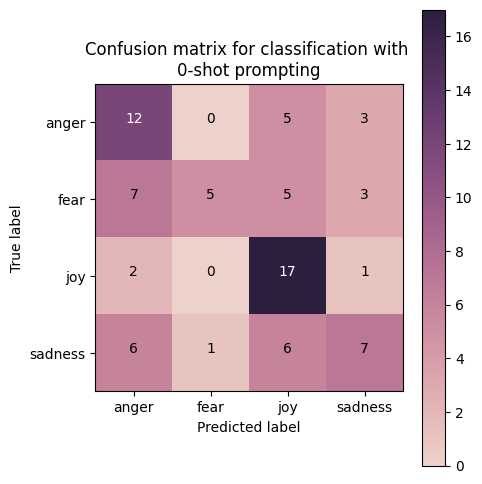

In [19]:
# If you see '429 RESOURCE_EXHAUSTED' errors it's fine, wait until the data gets processed, it will keep retrying until it finishes

# Example of running the experiment with zero-shot prompting
run_experiment(train_df, test_df, num_test_samples=20, num_shots=0)


You will be given a text extracted from social media and your task is to classify the text into one of the following emotion categories: 
"anger" | "fear" | "joy" | "sadness"
    

Examples: 
Text: Like hello? I am your first born you must always laugh at my jokes. 
Class: anger

Text: #ObamaLegacy - weekly #riots and #terror attacks, &gt;400k dead #Syrians, #Jews fleeing #persecution in Europe, #Christian #genocide in ME.....
Class: fear

Text: But i'll be a pity. 🐑 #lively
Class: joy

Text: @KhoroshiySoldat --prepared.\n\n'Not as far as I know.' was her dull reply. 'There are still survivors, members from it. Like I said,-/
Class: sadness




Processing samples for emotion: anger...:  75%|███████▌  | 15/20 [00:12<00:03,  1.31it/s]

Rate limit of 15 requests per minute reached. Waiting for 47.98 seconds.


Processing samples for emotion: fear...:  50%|█████     | 10/20 [00:08<00:07,  1.26it/s]

Rate limit of 15 requests per minute reached. Waiting for 48.21 seconds.


Processing samples for emotion: joy...:  25%|██▌       | 5/20 [00:03<00:10,  1.41it/s]

Rate limit of 15 requests per minute reached. Waiting for 47.86 seconds.


Processing samples for emotion: sadness...:   0%|          | 0/20 [00:00<?, ?it/s]

Rate limit of 15 requests per minute reached. Waiting for 47.05 seconds.


Processing samples for emotion: sadness...:  75%|███████▌  | 15/20 [00:59<00:04,  1.13it/s]

Rate limit of 15 requests per minute reached. Waiting for 47.82 seconds.


Processing samples for emotion: sadness...: 100%|██████████| 20/20 [01:51<00:00,  5.58s/it]


Results saved to ./results/llm_classification_results/results_samples_20_shots_1.csv
Accuracy: 60.00%
              precision    recall  f1-score   support

       anger       0.54      0.75      0.62        20
        fear       1.00      0.30      0.46        20
         joy       0.62      0.90      0.73        20
     sadness       0.53      0.45      0.49        20

    accuracy                           0.60        80
   macro avg       0.67      0.60      0.58        80
weighted avg       0.67      0.60      0.58        80



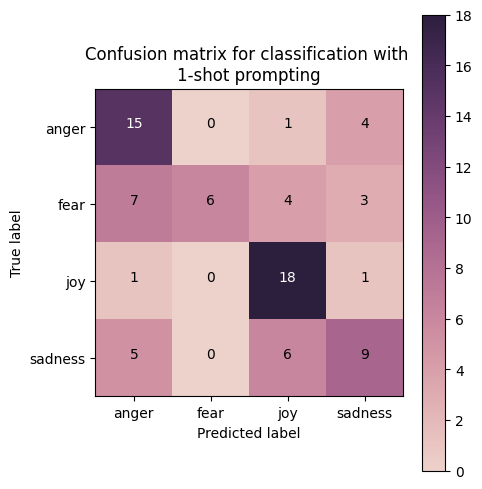

In [21]:
# If you see '429 RESOURCE_EXHAUSTED' errors it's fine, wait until the data gets processed, it will keep retrying until it finishes

# Example of running the experiment with 1-shot prompting
run_experiment(train_df, test_df, num_test_samples=20, num_shots=1)


You will be given a text extracted from social media and your task is to classify the text into one of the following emotion categories: 
"anger" | "fear" | "joy" | "sadness"
    

Examples: 
Text: Like hello? I am your first born you must always laugh at my jokes. 
Class: anger

Text: the bee sting still suck i feel sick
Class: anger

Text: I just wanna know why there's no outrage for black on black crime and no one knows those victims but BLM is out to kill cops based on media
Class: anger

Text: When you've still got a whole season of Wentworth to watch and a stupid cunt in work ruins it for us 😭😭 @__KirstyGA #raging #oldcunt
Class: anger

Text: @len_snart gives a frustrated growl, before stepping closer and putting his gun through the barrier. No alarms and nothing happened. He-
Class: anger

Text: #ObamaLegacy - weekly #riots and #terror attacks, &gt;400k dead #Syrians, #Jews fleeing #persecution in Europe, #Christian #genocide in ME.....
Class: fear

Text: @AllyTheRipper @ProoF 

Processing samples for emotion: anger...:  75%|███████▌  | 15/20 [00:11<00:03,  1.60it/s]

Rate limit of 15 requests per minute reached. Waiting for 48.50 seconds.


Processing samples for emotion: fear...:  50%|█████     | 10/20 [00:07<00:06,  1.53it/s]

Rate limit of 15 requests per minute reached. Waiting for 48.14 seconds.


Processing samples for emotion: joy...:  25%|██▌       | 5/20 [00:03<00:10,  1.38it/s]

Rate limit of 15 requests per minute reached. Waiting for 48.08 seconds.


Processing samples for emotion: sadness...:   0%|          | 0/20 [00:00<?, ?it/s]

Rate limit of 15 requests per minute reached. Waiting for 47.74 seconds.


Processing samples for emotion: sadness...:  75%|███████▌  | 15/20 [00:59<00:03,  1.32it/s]

Rate limit of 15 requests per minute reached. Waiting for 48.53 seconds.


Processing samples for emotion: sadness...: 100%|██████████| 20/20 [01:51<00:00,  5.59s/it]


Results saved to ./results/llm_classification_results/results_samples_20_shots_5.csv
Accuracy: 56.25%
              precision    recall  f1-score   support

       anger       0.48      0.60      0.53        20
        fear       1.00      0.35      0.52        20
         joy       0.67      0.80      0.73        20
     sadness       0.42      0.50      0.45        20

    accuracy                           0.56        80
   macro avg       0.64      0.56      0.56        80
weighted avg       0.64      0.56      0.56        80



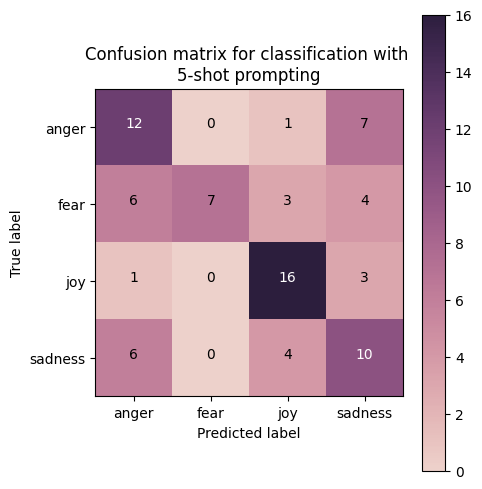

In [22]:
# If you see '429 RESOURCE_EXHAUSTED' errors it's fine, wait until the data gets processed, it will keep retrying until it finishes

# Example of running the experiment with 5-shot prompting
run_experiment(train_df, test_df, num_test_samples=20, num_shots=5)

---
##### <a id='toc1_5_10_1_1_'></a>[**>>> Exercise 6 (Take home):**](#toc0_)

Compare and discuss the overall results of the zero-shot, 1-shot and 5-shot classification.

In [ ]:
# Answer here
"""
Similar to the findings in the UMAP visualization, the model performs best when classifying "joy" related texts, likely due to their distinct linguistic patterns compared to negative emotions.

As for the prompting strategies, while 1-shot prompting provided a noticeable boost in accuracy over zero-shot, the jump to 5-shot prompting yielded diminishing and even negative returns in some cases. This suggests that while providing examples helps the model understand the task better, too many examples may introduce noise or confusion, especially when the examples are inherently perplexing or overlapping in nature.
"""

---
##### <a id='toc1_5_10_1_2_'></a>[**>>> Exercise 7 (Take home):**](#toc0_)

**Case Study:** Check the results' files inside the `results/llm_classification_results` directory and find cases where the **text classification improves with more examples** (pred emotion is right with examples), **cases where it does not improve** (pred emotion always wrong) and **cases where the classification got worse with more examples** (pred emotion goes from right to wrong with examples). For this you need to load the results with pandas and handle the data using its dataframe functions. Discuss about the findings.

In [80]:
# Answer here
df_0shot = pd.read_csv("./results/llm_classification_results/results_samples_20_shots_0.csv")
df_1shot = pd.read_csv("./results/llm_classification_results/results_samples_20_shots_1.csv")
df_5shot = pd.read_csv("./results/llm_classification_results/results_samples_20_shots_5.csv")

In [84]:
df_0shot.head()

,text,true_emotion,predicted_emotion
0,@RevTrevK @Wolfman93011 @Daraidernation @EROCK...,anger,anger
1,I think @Sam_Canaday &amp; @KYLEJDOWSON must a...,anger,sadness
2,"Why to have vanity sizes?Now sizes S,XS(evenXX...",anger,anger
3,"I miss my gran singing Rawhide, in her deep ba...",anger,sadness
4,I wouldn't have #anger issues.....if she didn'...,anger,anger


In [85]:
df_1shot.head()

,text,true_emotion,predicted_emotion
0,@RevTrevK @Wolfman93011 @Daraidernation @EROCK...,anger,sadness
1,I think @Sam_Canaday &amp; @KYLEJDOWSON must a...,anger,sadness
2,"Why to have vanity sizes?Now sizes S,XS(evenXX...",anger,anger
3,"I miss my gran singing Rawhide, in her deep ba...",anger,sadness
4,I wouldn't have #anger issues.....if she didn'...,anger,anger


In [91]:
df_combined = df_0shot.copy()
df_combined = df_combined.join(df_1shot[['predicted_emotion']], rsuffix='_1shot', how='inner')
df_combined = df_combined.join(df_5shot[['predicted_emotion']], rsuffix='_5shot', how='inner')
df_combined = df_combined.rename(columns={"predicted_emotion": "predicted_emotion_0shot"})
df_combined["correct_0shot"] = df_combined["true_emotion"] == df_combined["predicted_emotion_0shot"]
df_combined["correct_1shot"] = df_combined["true_emotion"] == df_combined["predicted_emotion_1shot"]
df_combined["correct_5shot"] = df_combined["true_emotion"] == df_combined["predicted_emotion_5shot"]

In [92]:
df_combined.head()

,text,true_emotion,predicted_emotion_0shot,predicted_emotion_1shot,predicted_emotion_5shot,correct_0shot,correct_1shot,correct_5shot
0,@RevTrevK @Wolfman93011 @Daraidernation @EROCK...,anger,anger,sadness,sadness,True,False,False
1,I think @Sam_Canaday &amp; @KYLEJDOWSON must a...,anger,sadness,sadness,sadness,False,False,False
2,"Why to have vanity sizes?Now sizes S,XS(evenXX...",anger,anger,anger,anger,True,True,True
3,"I miss my gran singing Rawhide, in her deep ba...",anger,sadness,sadness,sadness,False,False,False
4,I wouldn't have #anger issues.....if she didn'...,anger,anger,anger,anger,True,True,True


In [100]:
# case where 5-shot >= 1-shot >= 0-shot
# avoid hiding overflow text
pd.set_option('display.max_colwidth', None)
df_combined[
    (df_combined['correct_5shot'] == True) &
    (df_combined['correct_5shot'] >= df_combined['correct_1shot']) &
    (df_combined['correct_1shot'] >= df_combined['correct_0shot']) &
    (df_combined['correct_0shot'] == False)
]

,text,true_emotion,predicted_emotion_0shot,predicted_emotion_1shot,predicted_emotion_5shot,correct_0shot,correct_1shot,correct_5shot
6,@LeonWobYP b***er off. NCFC is a grudge match :),anger,joy,anger,anger,False,True,True
17,@LiamCannon1 He's just too raging to type properly... Ha ha!,anger,joy,anger,anger,False,True,True
18,@fluffysoftlouis no no. I insist that you give me your best insult first,anger,joy,anger,anger,False,True,True
21,Bout ta get my @dontbreathe on up in here! @WarrenTheaters #icantholdmybreaththatlong,fear,joy,joy,fear,False,False,True
26,@joey_coops yes Hun! Avoid at all costs!! #nightmare,fear,anger,fear,fear,False,True,True
61,Soooo badly want to dye my hair dark but have never been dark before soooo torn 😭😭😭,sadness,fear,sadness,sadness,False,True,True
67,im thoroughly in love w zen and jumin and i dont think id even have the patience for either of them irl im old and weary,sadness,joy,sadness,sadness,False,True,True
68,Might go on @RadioX tomorrow to hopefully win a new car. My current one stinks of gone off milk. #grim,sadness,joy,joy,sadness,False,False,True


In [ ]:
"""
A shared characteristic of these examples is their sarcasmtic tone. The model seems to struggle with sarcasm in zero-shot settings, misclassifying them often as "joy" due to the presence of positive words. However, with the introduction of examples in 1-shot and 5-shot prompting, the model appears to better grasp the sarcastic context, leading to correct classifications as "anger" or "sadness".
"""

In [101]:
# case where always wrong

df_combined[
    (df_combined['correct_5shot'] == False) &
    (df_combined['correct_1shot'] == False) &
    (df_combined['correct_0shot'] == False)
]

,text,true_emotion,predicted_emotion_0shot,predicted_emotion_1shot,predicted_emotion_5shot,correct_0shot,correct_1shot,correct_5shot
1,I think @Sam_Canaday &amp; @KYLEJDOWSON must actually have to be working like me &amp; @dowson_brady because I havent got any snap chat videos today,anger,sadness,sadness,sadness,False,False,False
3,"I miss my gran singing Rawhide, in her deep baritone growl.",anger,sadness,sadness,sadness,False,False,False
7,Having a baby born too soon is #lifechanging 6 years on and it feels like only yesterday #sad #happy #angry #emotionalrollercoaster,anger,sadness,sadness,sadness,False,False,False
8,#oow16 #sting decent new song,anger,joy,joy,joy,False,False,False
20,Losing to Villa...'@M0tivati0nQuote: Most of the things people worry about are things that won't even matter to them a few months from now.',fear,sadness,sadness,sadness,False,False,False
22,Southend players always haunt Man U,fear,anger,anger,anger,False,False,False
24,"Ever been really lonely and your phone keeps blowing up, but you just can’t pick it up and respond to people? #recluse #issues",fear,sadness,sadness,sadness,False,False,False
25,@AttentiAlGatto LOL! Why would it scare me? It doesn't make any sense at all but it doesn't scare me! {chuckles},fear,joy,joy,joy,False,False,False
28,Hillary Clinton looked the other way to the Saudi war on women and their terror financing because they bought her off.,fear,anger,anger,anger,False,False,False
29,My Modern Proverb: 'Don't let anyone intimidate you about being single; most marriages end in divorce.',fear,joy,joy,joy,False,False,False


In [ ]:
"""
These examples (except #70) are quite ambiguous and could be interpreted in multiple ways, and the sarcastic tone further complicates the classification. In other words, there are two factors at play here: (i) inherent ambiguity in the negative emotions, and (ii) the presence of sarcasm.
"""

In [102]:
# case where 0-shot >= 1-shot >= 5-shot
df_combined[
    (df_combined['correct_0shot'] == True) &
    (df_combined['correct_0shot'] >= df_combined['correct_1shot']) &
    (df_combined['correct_1shot'] >= df_combined['correct_5shot']) &
    (df_combined['correct_5shot'] == False)
]

,text,true_emotion,predicted_emotion_0shot,predicted_emotion_1shot,predicted_emotion_5shot,correct_0shot,correct_1shot,correct_5shot
0,@RevTrevK @Wolfman93011 @Daraidernation @EROCKhd Take 2k out of it the numbers on madden are low and have dropped and people are unhappy,anger,anger,sadness,sadness,True,False,False
10,@RealJamesWoods @KennyCoble saddest part of this whole mess is that all of this #anger is #misdirected they should march 2 the #WhiteHouse,anger,anger,anger,sadness,True,True,False
16,Sting is just too damn earnest for early morning listening. #sting,anger,anger,anger,sadness,True,True,False
51,"@diehimbeertonis She developed her 'forced smile'. I can force myself to describe it 'a little hearty maybe, sanki biraz':)",joy,joy,joy,sadness,True,True,False


In [ ]:
"""
These examples illustrate how increasing the number of shots can sometimes (not always!) make the model overfit to certain words or phrases, such as:
- Example #0: "... and people are unhappy"
- Example #10: "... saddest part of this whole mess ..."

There are also cases where the actual cause of misclassification is unclear:

- Example #16: the actual cause of misclassification is unknown, and it's likely due to the ambiguity of "anger" and "sadness" in this context.
- Example #51: "... 'forced smile' ..." (misinterpreted as sarcasm for joy?)
"""

'\nThese examples illustrate how increasing the number of shots can sometimes (not always!) make the model overfit to certain words or phrases, such as:\n- Example #0: "... and people are unhappy"\n- Example #10: "... saddest part of this whole mess ..."\n- Example #16: the actual culprit word is unknown, and it\'s likely due to the ambiguity of "anger" and "sadness" in this context.\n- Example #51: "... \'forced smile\' ..." (misinterpreted as sarcasm for joy?)\n'

---
### <a id='toc1_5_11_'></a>[**2.7 Extra LLM Related Materials:**](#toc0_)
So this will be it for the lab, but here are some extra materials if you would like to explore:

- **How to use OpenAI ChatGPT model's API (Not Free API):** [Basics Video](https://www.youtube.com/watch?v=e9P7FLi5Zy8), [Basics GitHub](https://github.com/gkamradt/langchain-tutorials/blob/main/chatapi/ChatAPI%20%2B%20LangChain%20Basics.ipynb), [RAG's Basics Video](https://www.youtube.com/watch?v=9AXP7tCI9PI&t=300s), [RAG's Basics GitHub](https://github.com/techleadhd/chatgpt-retrieval)

- **Advanced topic - QLoRA (Quantized Low-Rank Adapter):** QLoRA is a method used to make fine-tuning large language models more efficient. It works by adding a small, trainable part (LoRA) to a pre-trained model, while keeping the rest of the model frozen. At the same time, it reduces the size of the model’s data using a process called quantization, which makes the model require less memory. This allows you to fine-tune large models without needing as much computational power, making it easier to adapt models for specific tasks. Materials: [Paper GitHub](https://github.com/artidoro/qlora?tab=readme-ov-file), [Llama 3 Application Video](https://www.youtube.com/watch?v=YJNbgusTSF0&t=512s),[Llama 3 Application GitHub](https://github.com/adidror005/youtube-videos/blob/main/LLAMA_3_Fine_Tuning_for_Sequence_Classification_Actual_Video.ipynb)

- **How to Fine-tune and run local LLMs with the `unsloth` library:** [unsloth tutorials](https://docs.unsloth.ai/models/tutorials-how-to-fine-tune-and-run-llms)

- **Google's Agent Development Kit Documentation:** [ADK](https://google.github.io/adk-docs/)

- **Build AI agents with LangGraph:** [LangGraph Documentation](https://langchain-ai.github.io/langgraph/concepts/why-langgraph/)

---